# **Anticipez les besoins en consommation électrique de bâtiments**
___
Cette étude en deux notebooks vise à estimer (prédire) les émissions de CO2 et la consommation totale d’énergie de bâtiments de la ville de Seattle en exploitant leurs données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction..) mises à disposition par la ville pour les années 2015 et 2016.
___

Cette étude est organisée en 2 notebooks: 
- Notebook de nettoyage, feature engineering et analyse exploratoire
- Notebook de modélisations et prédictions

___
## Notebook 2 : Modélisations et prédictions

La première partie nous a permis de réaliser un nettoyage des fichiers et une courte analyse exploratoire.      
Dans cette seconde partie, nous allons réaliser les diverses **modélisations grâce à des approches linéaires et non-linéaire afin de prédire les émissions de CO2 et les consommations d'énergie des bâtiments**.

## 0. MISE EN PLACE

 Nous commençons par mettre en place notre cadre de travail en effectuant les actions suivantes :
 - Importation des librairies et packages Python nécessaires
 - Importation des fonctions utiles implémentées 
 - Chargement du jeu de données

___
### 0.1 Importation des librairies Python nécessaires

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import category_encoders as ce
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, RobustScaler
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet,ElasticNetCV
from sklearn import svm
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import time

___
### 0.2 Importation des fonctions utiles

Par soucis de clarté (lisibilité) et afin d'assurer un meilleur confort de lecture de ce notebook, les fonctions implémentées pour la manipulation des données et la réalisation des graphiques ont été regroupées dans le fichier project_functions.py.

Ces fonctions sont importées via la ligne de code ci-dessous:

In [3]:
import project_functions as pf

___
### 0.3 Chargement du jeu de données

In [4]:
data = pd.read_csv("building-energy-cleaned.csv", sep=",").iloc[:, 1:]
data.head()

,DataYear,BuildingType,PrimaryPropertyType,Neighborhood,LargestPropertyUseType,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,BuildingAge,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate
0,2015,NONRESIDENTIAL,RETAIL STORE,DOWNTOWN,Unknown,47.611711,-122.336816,1.0,4.0,111077.0,91.0,9898724.0,0.0,9899135.0,0.0,69.01,26,1,1.00000,0.00000
1,2015,NONRESIDENTIAL,SMALL- AND MID-SIZED OFFICE,DOWNTOWN,OFFICE,47.606799,-122.337100,1.0,6.0,98370.0,45.0,6525887.0,0.0,6488262.0,37893.0,47.24,109,1,0.73651,0.26349
2,2015,NONRESIDENTIAL,LARGE OFFICE,LAKE UNION,OFFICE,47.621476,-122.343050,1.0,4.0,193788.0,59.0,16760217.0,0.0,16760914.0,0.0,116.84,68,5,0.80466,0.19534
3,2015,NONRESIDENTIAL,SMALL- AND MID-SIZED OFFICE,GREATER DUWAMISH,OFFICE,47.570897,-122.297412,1.0,3.0,76598.0,76.0,4476997.0,0.0,2234200.0,2242889.0,134.69,7,2,0.72049,0.27951
4,2015,NONRESIDENTIAL,LARGE OFFICE,LAKE UNION,OFFICE,47.621243,-122.329786,1.0,4.0,186971.0,86.0,12662456.0,0.0,9657951.0,3004906.0,226.92,34,2,1.00000,0.00000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1574 entries, 0 to 1573
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DataYear                1574 non-null   int64  
 1   BuildingType            1574 non-null   object 
 2   PrimaryPropertyType     1574 non-null   object 
 3   Neighborhood            1574 non-null   object 
 4   LargestPropertyUseType  1574 non-null   object 
 5   Latitude                1574 non-null   float64
 6   Longitude               1574 non-null   float64
 7   NumberofBuildings       1574 non-null   float64
 8   NumberofFloors          1574 non-null   float64
 9   PropertyGFATotal        1574 non-null   float64
 10  ENERGYSTARScore         1042 non-null   float64
 11  SiteEnergyUse(kBtu)     1574 non-null   float64
 12  SteamUse(kBtu)          1574 non-null   float64
 13  Electricity(kBtu)       1574 non-null   float64
 14  NaturalGas(kBtu)        1574 non-null   

In [6]:
data.describe()

,DataYear,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,BuildingAge,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate
count,1574.000000,1574.000000,1574.000000,1574.000000,1574.000000,1.574000e+03,1042.000000,1.574000e+03,1.574000e+03,1.574000e+03,1.574000e+03,1574.000000,1574.000000,1574.000000,1574.000000,1574.000000
mean,2015.982846,47.616467,-122.333511,1.089263,4.259212,1.150719e+05,63.021593,8.309086e+06,4.936906e+05,5.736174e+06,2.043136e+06,186.606255,54.456163,1.949174,0.933053,0.066947
std,0.129885,0.046855,0.023270,0.916823,6.735406,1.967706e+05,28.431588,2.227725e+07,5.126865e+06,1.374965e+07,9.750639e+06,721.904317,32.955965,1.243402,0.143068,0.143068
min,2015.000000,47.509590,-122.411820,0.500000,0.000000,1.128500e+04,1.000000,5.526710e+04,0.000000e+00,7.000000e+00,0.000000e+00,0.385000,1.000000,1.000000,-0.251160,-0.000010
25%,2016.000000,47.588039,-122.343118,1.000000,1.000000,2.881100e+04,43.625000,1.237582e+06,0.000000e+00,7.399850e+05,0.000000e+00,20.577500,27.000000,1.000000,1.000000,0.000000
50%,2016.000000,47.612710,-122.333195,1.000000,2.000000,4.815900e+04,69.500000,2.673010e+06,0.000000e+00,1.753855e+06,4.829538e+05,50.860000,51.000000,2.000000,1.000000,0.000000
75%,2016.000000,47.648675,-122.322660,1.000000,4.000000,1.078405e+05,87.000000,7.302778e+06,0.000000e+00,5.242171e+06,1.526990e+06,145.045000,86.750000,2.000000,1.000000,0.000000
max,2016.000000,47.733870,-122.261800,20.000000,99.000000,2.200000e+06,100.000000,4.483853e+08,1.314066e+08,2.796294e+08,2.979090e+08,16870.980000,116.000000,13.000000,1.000010,1.251160


___
### 0.4 Choix des critères d'évaluation des modèles

Les métriques que nous allons utiliser sont :
- R2 : coefficient de détermination
- MAE (Mean Absolute Error): l'erreur absolue moyenne

## 1. PREPROCESSING

### 1.1 Suppression des colonnes liées aux relevés énergétiques

Notre objectif est de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées. Notre prédiction devra se baser sur les données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction..). **Nous allons donc exclure toutes les données de relève énergétiques de notre dataset pour éviter une fuite de données**  

In [7]:
data = data.drop(['SteamUse(kBtu)','Electricity(kBtu)',
                         'NaturalGas(kBtu)'], axis=1)

### 1.2 Encodage et standardisation des features

Nous allons séparer les données numériques et les données catégorielles de notre dataset :

In [8]:
numerical_features = data.select_dtypes(include=['int64','float64'])
categorical_features = data.select_dtypes(exclude=['int64','float64']) 

In [9]:
categorical_features.nunique()

BuildingType               5
PrimaryPropertyType       22
Neighborhood              14
LargestPropertyUseType    57
dtype: int64

Ces variables catégorielles doivent être encodées avant d'être passées aux modèles d'apprentissage

Pour toutes ces variables, nous utiliserons la méthode **TagetEncoder** de la librairie Category_Encoders que nous intégrerons dans un pipeline Sklearn.     
Cet encodeur réalise 2 principales étapes :
1. Groupe les données par chaque catégorie et compte de nombre d'occurrences de chaque cible.
2. Calcul de la probabilité que chaque cible se produise pour chaque groupe spécifique.

Regardons maintenant les données numériques :

In [10]:
list(numerical_features.columns)

['DataYear',
 'Latitude',
 'Longitude',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'ENERGYSTARScore',
 'SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',
 'BuildingAge',
 'TotalUseTypeNumber',
 'GFABuildingRate',
 'GFAParkingRate']

In [11]:
energystar_score = numerical_features['ENERGYSTARScore']
numerical_features = numerical_features.drop(['ENERGYSTARScore','DataYear'], axis=1)

Les données numériques doivent être standardisées pour entrer dans nos modèles de prédiction. Nous réaliserons un **centrage-réduction** via la méthode `RobustScaler` de Scikit-Learn.

In [12]:
data_filter = pd.concat([categorical_features, numerical_features], axis=1)

#### Préparation du Preprocessor

In [13]:
#TargetEncoder
target_features = ['BuildingType','PrimaryPropertyType','Neighborhood','LargestPropertyUseType']
target_transformer = TargetEncoder()

#Standardisation
numeric_features = ['NumberofBuildings','NumberofFloors',
                    'PropertyGFATotal','BuildingAge','TotalUseTypeNumber',
                    'GFABuildingRate','GFAParkingRate']
numeric_transformer = RobustScaler(unit_variance=True)

preprocessor = ColumnTransformer(transformers=[
    ('target', target_transformer, target_features),
    ('numeric', numeric_transformer, numeric_features)
])

### 1.3 Préparation des jeux d'entrainement et de test

Afin de **tester notre meilleur modèle** sur des données "inconnues", nous allons mettre de côté une partie des données initiales qui ne seront pas inclusent dans les modèles intermédiaires. Nous allons donc spliter nos données pour obtenir un jeu d'entrainement et un jeu de test *(20% des données)*

In [14]:
Y = data_filter[['TotalGHGEmissions','SiteEnergyUse(kBtu)']]
X = data_filter.drop(['TotalGHGEmissions','SiteEnergyUse(kBtu)'], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))

Entrainement: 1259 lignes,
Test: 315 lignes.



Concernant nos variables à prédire, nous allons regarder l'**impact du passage à l'échelle logarithmique sur les distribution** :

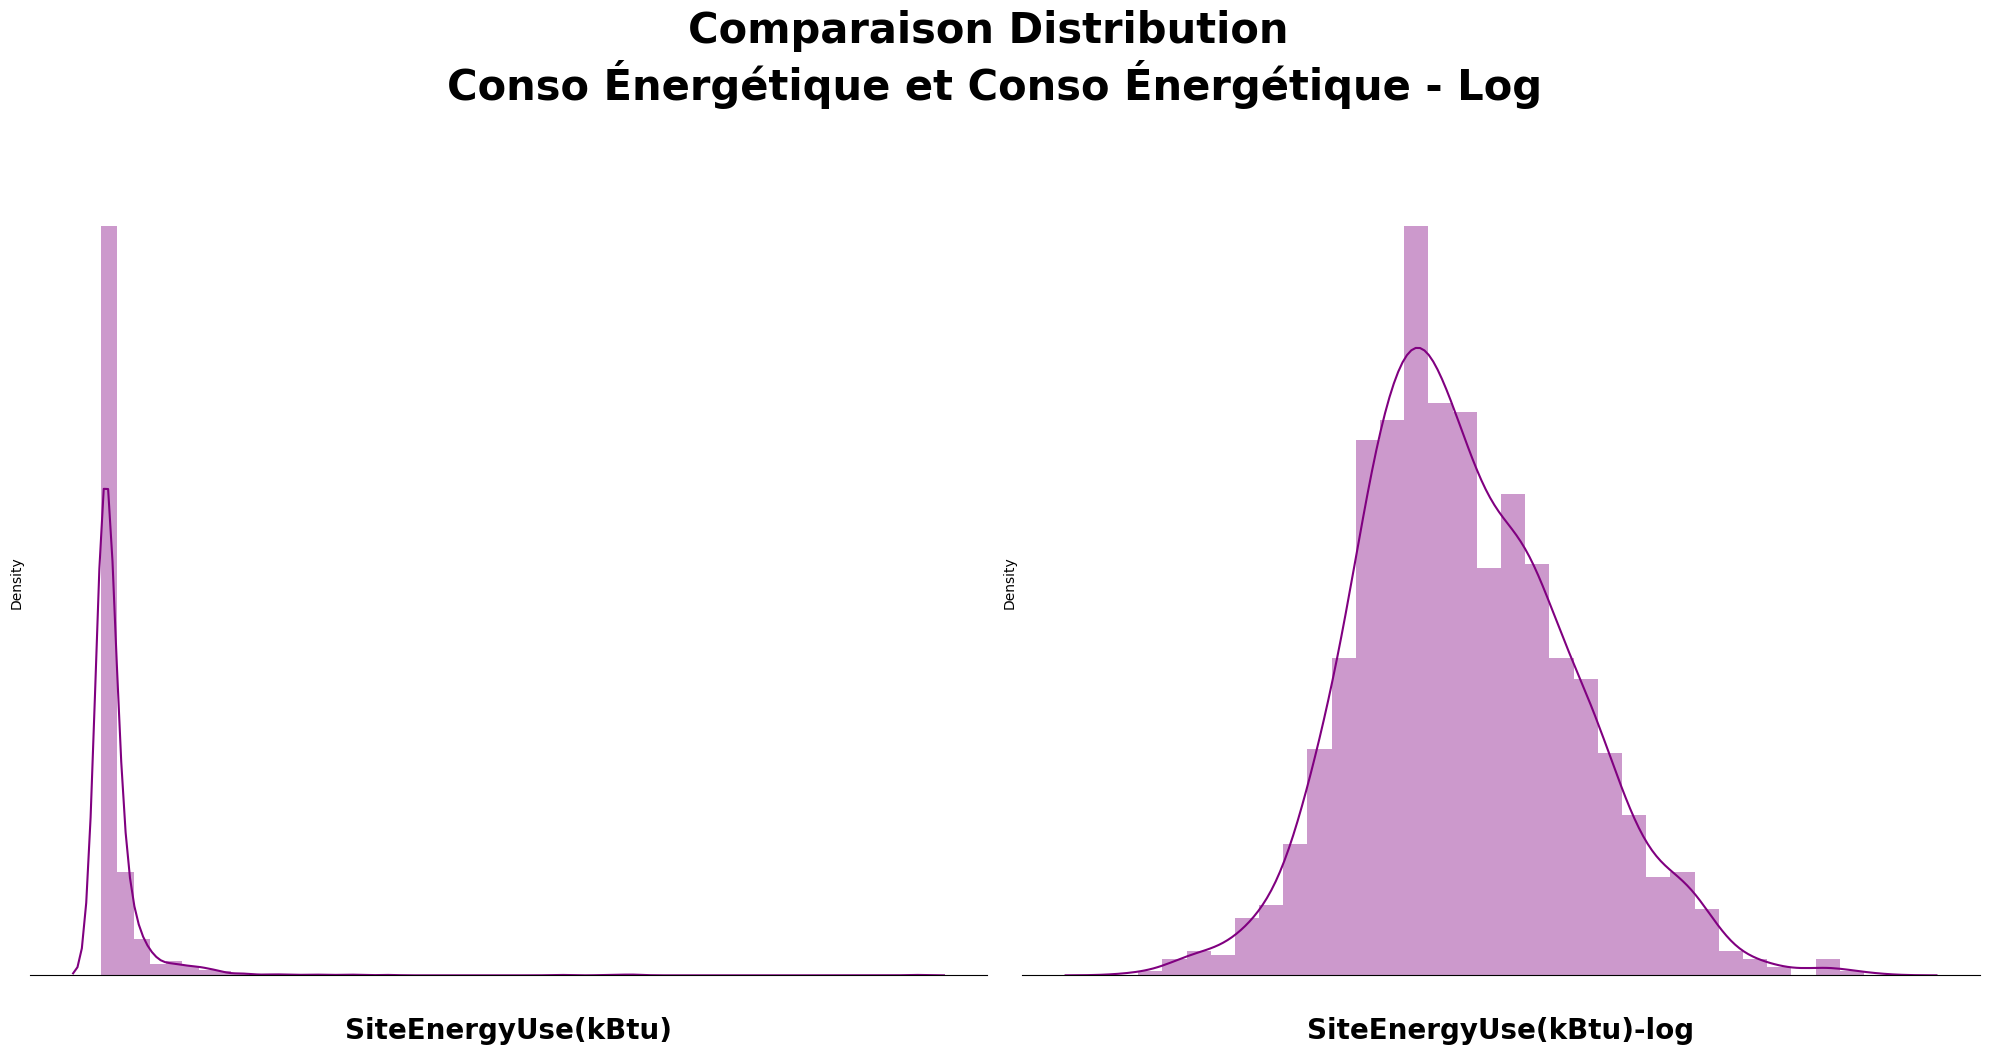

In [15]:
pf.plot2Distplots(data_filter["SiteEnergyUse(kBtu)"], "SiteEnergyUse(kBtu)",
                  np.log(data_filter["SiteEnergyUse(kBtu)"]), "SiteEnergyUse(kBtu)-log",
                  20, 10, "Comparaison Distribution \nConso Énergétique et Conso Énergétique - Log")

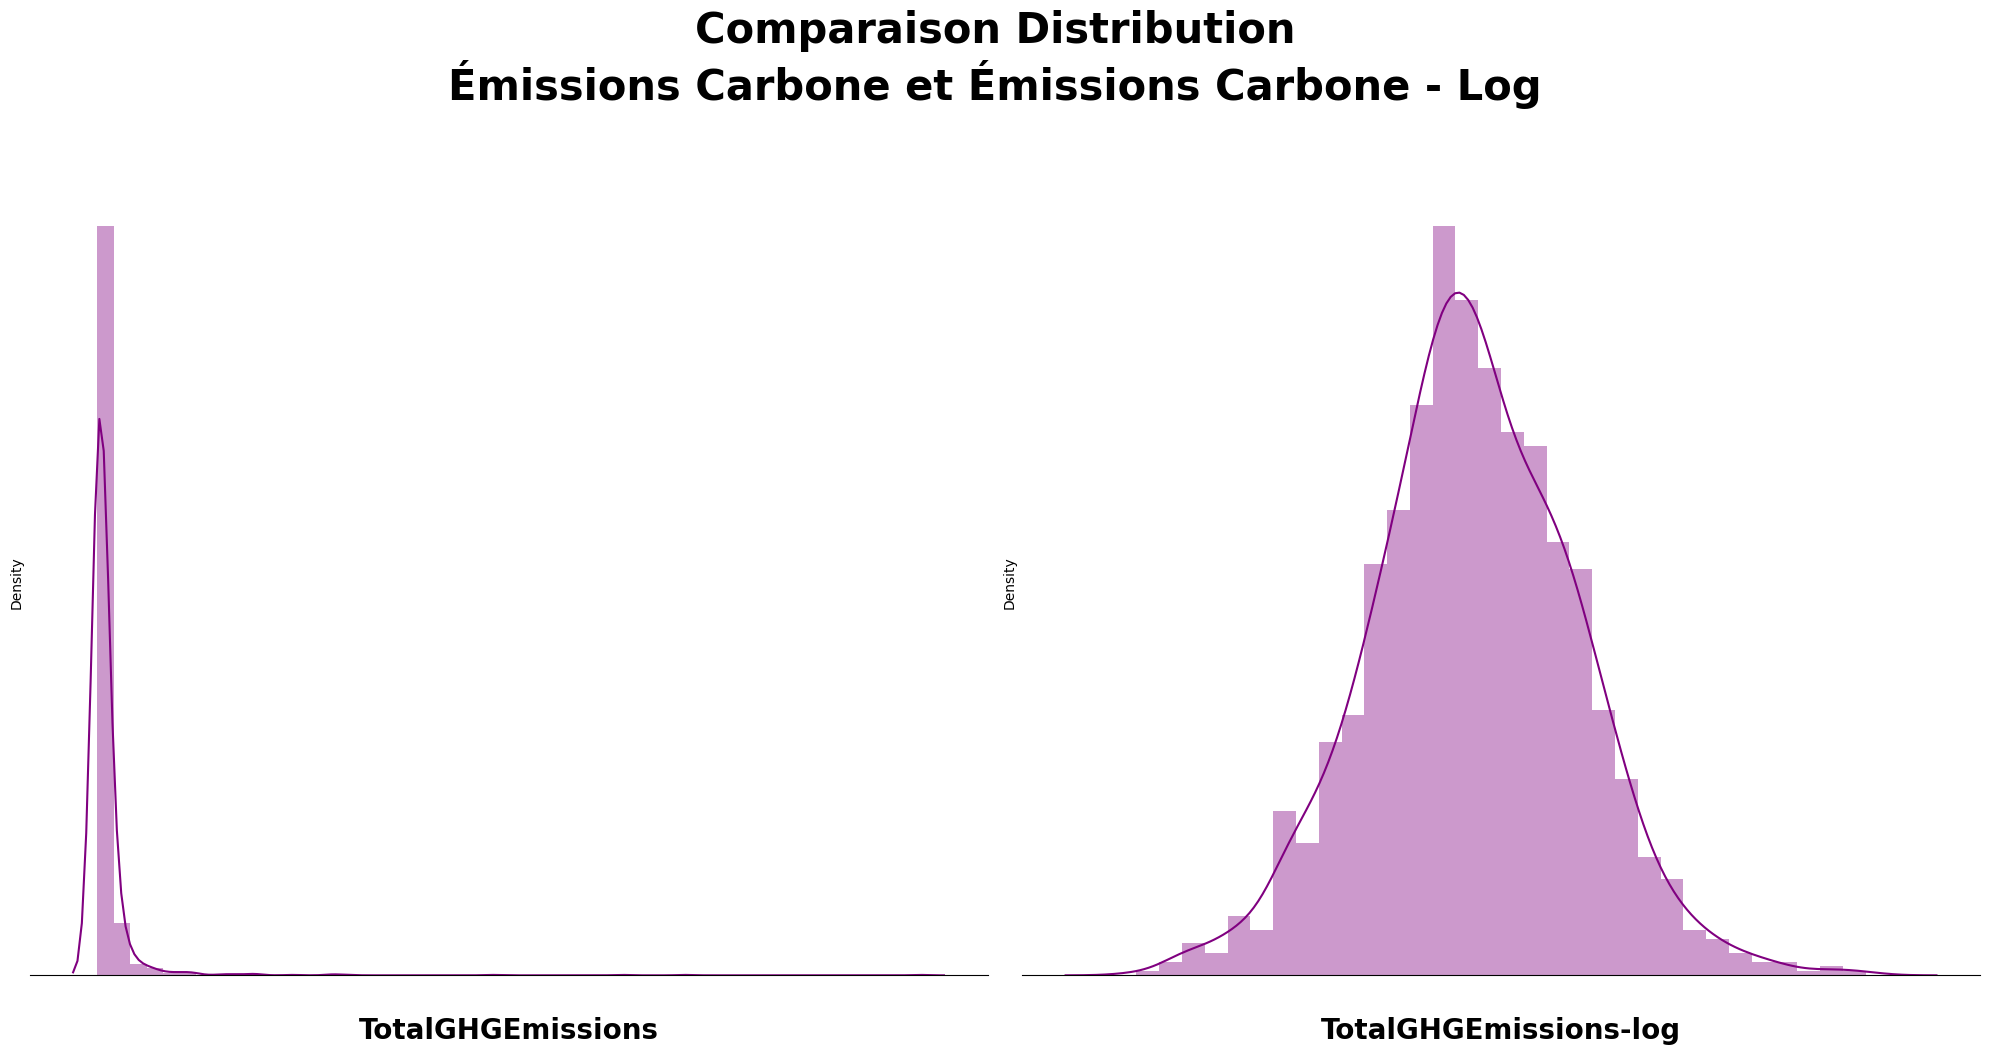

In [16]:
pf.plot2Distplots(data_filter["TotalGHGEmissions"], "TotalGHGEmissions",
                  np.log(data_filter["TotalGHGEmissions"]), "TotalGHGEmissions-log",
                  20, 10, "Comparaison Distribution\nÉmissions Carbone et Émissions Carbone - Log")

En passant les données à l'échelle logarithmique, nous obtenons une distribution normale des données à prédire. Nous allons donc appliquer cette transformation dans notre pipeline grâce à la fonction `TransformedTargetRegressor` de la librairie Sklearn.

La fonction inverse (exp) sera donc passée dans les prédictions.

## 2. MODELISATIONS

Plusieurs algorithmes de différentes familles seront testés afin de déterminer lequel se comporte le mieux face au problème posé. Tous les modèles seront optimisés par validation croisée (GridSearchCV).


In [17]:
SEU_r2_mae_time = pd.DataFrame(columns=["MAE", "R2", "Time"])
GHG_r2_mae_time = pd.DataFrame(columns=["MAE", "R2", "Time"])

### 2.1 Algorithme 0 - Baseline : Régression linéaire multiple

Nous allons créer un modèle baseline pour évaluer les performances de nos futurs modèles et vérifier qu'ils améliore les prédictions. Pour cette baseline, nous utiliserons une **régression linéaire multivariée**.

In [18]:
set_config(display='diagram')

#Les paramètres du modèle
param_mlr = {"regressor__fit_intercept": [True, False],
             "regressor__normalize": [True, False]}

mlr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_mlr', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=LinearRegression(), 
                                func=np.log, 
                                inverse_func=np.exp),
                            param_grid=param_mlr,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = -1))])

#### 2.1.1 Scores de la GridSearch avec validation croisée pour la variable `SiteEnergyUse(kBtu)` :

In [19]:
#Entrainement
SEU_mlr_model = mlr_grid_cv.fit(X_train,Y_train['SiteEnergyUse(kBtu)'])
#Récupération des scores
SEU_mlr_results = pf.model_scores(SEU_mlr_model, 'grid_search_mlr', X_train)

Meilleur score MAE : -31769145.758
Meilleur Score R2 : -346.493
Meilleurs paramètres : {'regressor__fit_intercept': True, 'regressor__normalize': False}
Temps moyen d'entrainement : 4.7s


In [20]:
# Sauvegarde des meilleurs scores du modèle
SEU_r2_mae_time.loc['LinearRegression', "MAE"] = SEU_mlr_results.loc[0, 'mean_test_neg_mean_absolute_error']
SEU_r2_mae_time.loc['LinearRegression', "R2"] = np.mean(SEU_mlr_results[SEU_mlr_results.rank_test_r2 == 1]['mean_test_r2'])
SEU_r2_mae_time.loc['LinearRegression', "Time"] = round((np.mean(SEU_mlr_results.mean_fit_time)*X_train.shape[0]),2)

SEU_r2_mae_time

,MAE,R2,Time
LinearRegression,-31876086.679196,-346.493345,4.7


#### 2.1.2 Scores de la GridSearch avec validation croisée pour la variable `TotalGHGEmissions` :

In [21]:
#Entrainement
GHG_mlr_model = mlr_grid_cv.fit(X_train, Y_train['TotalGHGEmissions'])
#Récupération des scores
GHG_mlr_results = pf.model_scores(GHG_mlr_model, 'grid_search_mlr', X_train)

Meilleur score MAE : -826.114
Meilleur Score R2 : -230.401
Meilleurs paramètres : {'regressor__fit_intercept': True, 'regressor__normalize': False}
Temps moyen d'entrainement : 3.36s


In [22]:
# Sauvegarde des meilleurs scores du modèle
GHG_r2_mae_time.loc['LinearRegression', "MAE"] = GHG_mlr_results.loc[0, 'mean_test_neg_mean_absolute_error']
GHG_r2_mae_time.loc['LinearRegression', "R2"] = np.mean(GHG_mlr_results[GHG_mlr_results.rank_test_r2 == 1]['mean_test_r2'])
GHG_r2_mae_time.loc['LinearRegression', "Time"] = round((np.mean(GHG_mlr_results.mean_fit_time)*X_train.shape[0]),2)

GHG_r2_mae_time

,MAE,R2,Time
LinearRegression,-835.673587,-230.401019,3.36


Tous les résultats des GridSearchCV sont stockés dans un DataFrame pour chaque variable à prédire 

In [23]:
SEU_mlr_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__fit_intercept,param_regressor__normalize,params,split0_test_r2,split1_test_r2,split2_test_r2,...,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,split3_train_neg_mean_absolute_error,split4_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error
1,0.004035,0.004228,0.003622,0.003682,True,False,"{'regressor__fit_intercept': True, 'regressor_...",-6.070526e+01,-0.527437,-1.485476e+03,...,-3.176915e+07,3.251378e+07,1,-1.639924e+07,-1.385258e+07,-1.394146e+07,-1.075128e+07,-1.702137e+07,-1.439319e+07,2.222226e+06
0,0.006445,0.005313,0.003213,0.003935,True,True,"{'regressor__fit_intercept': True, 'regressor_...",-6.070526e+01,-0.527437,-1.504317e+03,...,-3.187609e+07,3.272185e+07,2,-1.639924e+07,-1.385258e+07,-1.401499e+07,-1.075128e+07,-1.702137e+07,-1.440789e+07,2.219429e+06
2,0.002422,0.003909,0.003214,0.003936,False,True,"{'regressor__fit_intercept': False, 'regressor...",-1.906040e+11,-588.881909,-1.669783e+13,...,-9.277118e+12,1.376783e+13,3,-3.119429e+12,-2.581100e+11,-3.116985e+12,-3.790887e+12,-1.047129e+13,-4.151340e+12,3.387142e+12
3,0.002015,0.003115,0.000407,0.000814,False,False,"{'regressor__fit_intercept': False, 'regressor...",-1.906040e+11,-588.881909,-1.669783e+13,...,-9.277118e+12,1.376783e+13,3,-3.119429e+12,-2.581100e+11,-3.116985e+12,-3.790887e+12,-1.047129e+13,-4.151340e+12,3.387142e+12


In [24]:
GHG_mlr_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__fit_intercept,param_regressor__normalize,params,split0_test_r2,split1_test_r2,split2_test_r2,...,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,split3_train_neg_mean_absolute_error,split4_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error
1,0.003125,0.006249,0.000000,0.000000,True,False,"{'regressor__fit_intercept': True, 'regressor_...",-28.500825,-0.070317,-874.716236,...,-826.114345,764.592500,1,-510.081458,-352.602974,-379.954410,-251.844078,-513.157817,-401.528147,99.508214
0,0.006241,0.007643,0.000000,0.000000,True,True,"{'regressor__fit_intercept': True, 'regressor_...",-28.500825,-0.070317,-916.109514,...,-835.673587,782.437301,2,-510.081458,-352.602974,-377.838929,-251.844078,-513.157817,-401.105051,99.603496
2,0.001302,0.002605,0.003125,0.006249,False,True,"{'regressor__fit_intercept': False, 'regressor...",-56.802801,-0.730462,-15178.994707,...,-7172.574336,5927.766344,3,-3517.306255,-2228.133807,-2447.149050,-1304.832262,-7447.058893,-3388.896053,2147.684945
3,0.000000,0.000000,0.000000,0.000000,False,False,"{'regressor__fit_intercept': False, 'regressor...",-56.802801,-0.730462,-15178.994707,...,-7172.574336,5927.766344,3,-3517.306255,-2228.133807,-2447.149050,-1304.832262,-7447.058893,-3388.896053,2147.684945


In [25]:
SEU_mlr_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('target', TargetEncoder(),
                                                  ['BuildingType',
                                                   'PrimaryPropertyType',
                                                   'Neighborhood',
                                                   'LargestPropertyUseType']),
                                                 ('numeric',
                                                  RobustScaler(unit_variance=True),
                                                  ['NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFATotal',
                                                   'BuildingAge',
                                                   'TotalUseTypeNumber',
                                                   'GFABuildingRate',
                                                   'GFAParkingRate'])])),
                ('grid_search_mlr',
                 GridSearchCV(cv=5,
                              estimator=TransformedTargetRegressor(func=<ufunc 'log'>,
                                                                   inverse_func=<ufunc 'exp'>,
                                                                   regressor=LinearRegression()),
                              n_jobs=-1,
                              param_grid={'regressor__fit_intercept': [True,
                                                                       False],
                                          'regressor__normalize': [True,
                                                                   False]},
                              refit='neg_mean_absolute_error',
                              return_train_score=True,
                              scoring=('r2', 'neg_mean_absolute_error')))])

Nous avons à présent nos métriques de départ obtenues avec notre modèle de régression linéaire multivarié servant de baseline. 

### 2.2 Algorithme 1 - Famille des modèles linéaires : Elastic Net

In [26]:
param_eNet = {"regressor__max_iter": [10, 100, 1000],
              "regressor__alpha": np.logspace(-4, 0, num=5),
              "regressor__l1_ratio": np.arange(0.0, 1.1, 0.1)}

eNet_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_enet', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=ElasticNet(), 
                                func=np.log, 
                                inverse_func=np.exp),
                            param_grid=param_eNet,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = -1))])

#### 2.2.1 Scores de la GridSearch avec validation croisée pour la variable `SiteEnergyUse(kBtu)` :

In [27]:
#Entrainement
SEU_eNet_model = eNet_grid_cv.fit(X_train,Y_train['SiteEnergyUse(kBtu)'])
#Récupération des scores
SEU_eNet_results = pf.model_scores(SEU_eNet_model, 'grid_search_enet', X_train)

Meilleur score MAE : -17861876.207
Meilleur Score R2 : -82.457
Meilleurs paramètres : {'regressor__alpha': 1.0, 'regressor__l1_ratio': 0.9, 'regressor__max_iter': 100}
Temps moyen d'entrainement : 7.92s


In [28]:
# Sauvegarde des meilleurs scores du modèle
SEU_r2_mae_time.loc['ElasticNet', "MAE"] = SEU_eNet_results.loc[0, 'mean_test_neg_mean_absolute_error']
SEU_r2_mae_time.loc['ElasticNet', "R2"] = np.mean(SEU_eNet_results[SEU_eNet_results.rank_test_r2 == 1]['mean_test_r2'])
SEU_r2_mae_time.loc['ElasticNet', "Time"] = round((np.mean(SEU_eNet_results.mean_fit_time)*X_train.shape[0]),2)

SEU_r2_mae_time

,MAE,R2,Time
LinearRegression,-31876086.679196,-346.493345,4.7
ElasticNet,-30519333.446128,-82.456825,7.92


#### 2.2.2 Scores de la GridSearch avec validation croisée pour la variable `TotalGHGEmissions` :

In [29]:
#Entrainement
GHG_eNet_model = eNet_grid_cv.fit(X_train, Y_train['TotalGHGEmissions'])
#Récupération des scores
GHG_eNet_results = pf.model_scores(GHG_eNet_model, 'grid_search_enet', X_train)

Meilleur score MAE : -351.292
Meilleur Score R2 : -26.261
Meilleurs paramètres : {'regressor__alpha': 1.0, 'regressor__l1_ratio': 1.0, 'regressor__max_iter': 1000}
Temps moyen d'entrainement : 7.77s


In [30]:
# Sauvegarde des meilleurs scores du modèle
GHG_r2_mae_time.loc['ElasticNet', "MAE"] = GHG_eNet_results.loc[0, 'mean_test_neg_mean_absolute_error']
GHG_r2_mae_time.loc['ElasticNet', "R2"] = np.mean(GHG_eNet_results[GHG_eNet_results.rank_test_r2 == 1]['mean_test_r2'])
GHG_r2_mae_time.loc['ElasticNet', "Time"] = round((np.mean(GHG_eNet_results.mean_fit_time)*X_train.shape[0]),2)

GHG_r2_mae_time

,MAE,R2,Time
LinearRegression,-835.673587,-230.401019,3.36
ElasticNet,-826.665054,-26.261464,7.77


In [31]:
SEU_eNet_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('target', TargetEncoder(),
                                                  ['BuildingType',
                                                   'PrimaryPropertyType',
                                                   'Neighborhood',
                                                   'LargestPropertyUseType']),
                                                 ('numeric',
                                                  RobustScaler(unit_variance=True),
                                                  ['NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFATotal',
                                                   'BuildingAge',
                                                   'TotalUseTypeNumber',
                                                   'GFABuildingRate',
                                                   'GFAParkingRate'])])),
                ('gr...
                              estimator=TransformedTargetRegressor(func=<ufunc 'log'>,
                                                                   inverse_func=<ufunc 'exp'>,
                                                                   regressor=ElasticNet()),
                              n_jobs=-1,
                              param_grid={'regressor__alpha': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]),
                                          'regressor__l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                          'regressor__max_iter': [10, 100,
                                                                  1000]},
                              refit='neg_mean_absolute_error',
                              return_train_score=True,
                              scoring=('r2', 'neg_mean_absolute_error')))])

### 2.3 Algorithme 2 - Famille des machines à vecteurs de support : Support Vector Regressor

In [32]:
param_svr = {'regressor__C' : np.logspace(-4, 0, 5),
             'regressor__epsilon' : [0, 0.01, 0.1, 0.5, 1, 2],
             'regressor__loss' : ["epsilon_insensitive","squared_epsilon_insensitive"],
             'regressor__max_iter': [10, 100, 1000]}

svr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_svr', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=LinearSVR(), 
                                func=np.log, 
                                inverse_func=np.exp),
                            param_grid=param_svr,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

#### 2.3.1 Scores de la GridSearch avec validation croisée pour la variable `SiteEnergyUse(kBtu)` :

In [33]:
#Entrainement
SEU_svr_model = svr_grid_cv.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])
#Récupération des scores
SEU_svr_results = pf.model_scores(SEU_svr_model, 'grid_search_svr', X_train)

Meilleur score MAE : -8260690.983
Meilleur Score R2 : -0.211
Meilleurs paramètres : {'regressor__C': 0.0001, 'regressor__epsilon': 0, 'regressor__loss': 'epsilon_insensitive', 'regressor__max_iter': 10}
Temps moyen d'entrainement : 35.81s


In [34]:
# Sauvegarde des meilleurs scores du modèle
SEU_r2_mae_time.loc['LinearSVR', "MAE"] = SEU_svr_results.loc[0, 'mean_test_neg_mean_absolute_error']
SEU_r2_mae_time.loc['LinearSVR', "R2"] = np.mean(SEU_svr_results[SEU_svr_results.rank_test_r2 == 1]['mean_test_r2'])
SEU_r2_mae_time.loc['LinearSVR', "Time"] = round((np.mean(SEU_svr_results.mean_fit_time)*X_train.shape[0]),2)

SEU_r2_mae_time

,MAE,R2,Time
LinearRegression,-31876086.679196,-346.493345,4.7
ElasticNet,-30519333.446128,-82.456825,7.92
LinearSVR,-8260690.982534,-0.210575,35.81


#### 2.3.2 Scores de la GridSearch avec validation croisée pour la variable `TotalGHGEmissions` :

In [35]:
#Entrainement
GHG_svr_model = svr_grid_cv.fit(X_train, Y_train['TotalGHGEmissions'])
#Récupération des scores
GHG_svr_results = pf.model_scores(GHG_svr_model, 'grid_search_svr', X_train)

Meilleur score MAE : -1531.952
Meilleur Score R2 : -1137.683
Meilleurs paramètres : {'regressor__C': 0.0001, 'regressor__epsilon': 2, 'regressor__loss': 'epsilon_insensitive', 'regressor__max_iter': 1000}
Temps moyen d'entrainement : 47.37s


In [36]:
# Sauvegarde des meilleurs scores du modèle
GHG_r2_mae_time.loc['LinearSVR', "MAE"] = GHG_svr_results.loc[0, 'mean_test_neg_mean_absolute_error']
GHG_r2_mae_time.loc['LinearSVR', "R2"] = np.mean(GHG_svr_results[GHG_svr_results.rank_test_r2 == 1]['mean_test_r2'])
GHG_r2_mae_time.loc['LinearSVR', "Time"] = round((np.mean(GHG_svr_results.mean_fit_time)*X_train.shape[0]),2)

GHG_r2_mae_time

,MAE,R2,Time
LinearRegression,-835.673587,-230.401019,3.36
ElasticNet,-826.665054,-26.261464,7.77
LinearSVR,-620539225640.060791,-1137.682772,47.37


In [37]:
SEU_svr_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('target', TargetEncoder(),
                                                  ['BuildingType',
                                                   'PrimaryPropertyType',
                                                   'Neighborhood',
                                                   'LargestPropertyUseType']),
                                                 ('numeric',
                                                  RobustScaler(unit_variance=True),
                                                  ['NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFATotal',
                                                   'BuildingAge',
                                                   'TotalUseTypeNumber',
                                                   'GFABuildingRate',
                                                   'GFAParkingRate'])])),
                ('gr...
                                                                   regressor=LinearSVR()),
                              n_jobs=-1,
                              param_grid={'regressor__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]),
                                          'regressor__epsilon': [0, 0.01, 0.1,
                                                                 0.5, 1, 2],
                                          'regressor__loss': ['epsilon_insensitive',
                                                              'squared_epsilon_insensitive'],
                                          'regressor__max_iter': [10, 100,
                                                                  1000]},
                              refit='neg_mean_absolute_error',
                              return_train_score=True,
                              scoring=('r2', 'neg_mean_absolute_error')))])

### 2.4 Algorithme 3 - Famille des plus proches voisins : K Neighbors Regressor

In [38]:
param_knr = {'regressor__weights': ['uniform', 'distance'], 
             'regressor__n_neighbors': [5, 10, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]}

knr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_knr', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=KNeighborsRegressor(), 
                                func=np.log, 
                                inverse_func=np.exp),
                            param_grid=param_knr,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

#### 2.4.1 Scores de la GridSearch avec validation croisée pour la variable `SiteEnergyUse(kBtu)` :

In [39]:
#Entrainement
SEU_knr_model = knr_grid_cv.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])
#Récupération des scores
SEU_knr_results = pf.model_scores(SEU_knr_model, 'grid_search_knr', X_train)

Meilleur score MAE : -4982387.013
Meilleur Score R2 : 0.423
Meilleurs paramètres : {'regressor__n_neighbors': 5, 'regressor__weights': 'uniform'}
Temps moyen d'entrainement : 8.89s


In [40]:
# Sauvegarde des meilleurs scores du modèle
SEU_r2_mae_time.loc['KNeighborsRegressor', "MAE"] = SEU_knr_results.loc[0, 'mean_test_neg_mean_absolute_error']
SEU_r2_mae_time.loc['KNeighborsRegressor', "R2"] = np.mean(SEU_knr_results[SEU_knr_results.rank_test_r2 == 1]['mean_test_r2'])
SEU_r2_mae_time.loc['KNeighborsRegressor', "Time"] = round((np.mean(SEU_knr_results.mean_fit_time)*X_train.shape[0]),2)

SEU_r2_mae_time

,MAE,R2,Time
LinearRegression,-31876086.679196,-346.493345,4.7
ElasticNet,-30519333.446128,-82.456825,7.92
LinearSVR,-8260690.982534,-0.210575,35.81
KNeighborsRegressor,-4982387.01345,0.423037,8.89


#### 2.4.2 Scores de la GridSearch avec validation croisée pour la variable `TotalGHGEmissions` :

In [41]:
#Entrainement
GHG_knr_model = knr_grid_cv.fit(X_train, Y_train['TotalGHGEmissions'])
#Récupération des scores
GHG_knr_results = pf.model_scores(GHG_knr_model, 'grid_search_knr', X_train)

Meilleur score MAE : -132.089
Meilleur Score R2 : 0.36
Meilleurs paramètres : {'regressor__n_neighbors': 60, 'regressor__weights': 'distance'}
Temps moyen d'entrainement : 8.88s


In [42]:
# Sauvegarde des meilleurs scores du modèle
GHG_r2_mae_time.loc['KNeighborsRegressor', "MAE"] = GHG_knr_results.loc[0, 'mean_test_neg_mean_absolute_error']
GHG_r2_mae_time.loc['KNeighborsRegressor', "R2"] = np.mean(GHG_knr_results[GHG_knr_results.rank_test_r2 == 1]['mean_test_r2'])
GHG_r2_mae_time.loc['KNeighborsRegressor', "Time"] = round((np.mean(GHG_knr_results.mean_fit_time)*X_train.shape[0]),2)

GHG_r2_mae_time

,MAE,R2,Time
LinearRegression,-835.673587,-230.401019,3.36
ElasticNet,-826.665054,-26.261464,7.77
LinearSVR,-620539225640.060791,-1137.682772,47.37
KNeighborsRegressor,-132.094119,0.360295,8.88


In [43]:
SEU_knr_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('target', TargetEncoder(),
                                                  ['BuildingType',
                                                   'PrimaryPropertyType',
                                                   'Neighborhood',
                                                   'LargestPropertyUseType']),
                                                 ('numeric',
                                                  RobustScaler(unit_variance=True),
                                                  ['NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFATotal',
                                                   'BuildingAge',
                                                   'TotalUseTypeNumber',
                                                   'GFABuildingRate',
                                                   'GFAParkingRate'])])),
                ('gr...
                 GridSearchCV(cv=5,
                              estimator=TransformedTargetRegressor(func=<ufunc 'log'>,
                                                                   inverse_func=<ufunc 'exp'>,
                                                                   regressor=KNeighborsRegressor()),
                              n_jobs=-1,
                              param_grid={'regressor__n_neighbors': [5, 10, 20,
                                                                     25, 30, 40,
                                                                     50, 60, 70,
                                                                     80, 90,
                                                                     100],
                                          'regressor__weights': ['uniform',
                                                                 'distance']},
                              refit='neg_mean_absolute_error',
                              return_train_score=True,
                              scoring=('r2', 'neg_mean_absolute_error')))])

### 2.5 Algorithme 4 - Famille des modèles ensemblistes : Random Forest Regressor

In [44]:
param_rfr = {'regressor__n_estimators': [100, 200, 500, 700, 1000],
             'regressor__max_features' : ['sqrt', 'log2'],
             'regressor__max_depth': [5, 15, 25, 50],
             'regressor__min_samples_split': [2, 5, 10],
             'regressor__bootstrap' : [True, False],
             'regressor__min_samples_leaf': [1,2,5,10]}

rfr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_rfr', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=RandomForestRegressor(), 
                                func=np.log, 
                                inverse_func=np.exp),
                            param_grid=param_rfr,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

#### 2.5.1 Scores de la GridSearch avec validation croisée pour la variable `SiteEnergyUse(kBtu)` :

In [45]:
#Entrainement
SEU_rfr_model = rfr_grid_cv.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])
#Récupération des scores
SEU_rfr_results = pf.model_scores(SEU_rfr_model, 'grid_search_rfr', X_train)

Meilleur score MAE : -3884568.321
Meilleur Score R2 : 0.604
Meilleurs paramètres : {'regressor__bootstrap': False, 'regressor__max_depth': 15, 'regressor__max_features': 'log2', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Temps moyen d'entrainement : 2525.01s


In [46]:
# Sauvegarde des meilleurs scores du modèle
SEU_r2_mae_time.loc['RandomForestRegressor', "MAE"] = SEU_rfr_model.named_steps['grid_search_rfr'].best_score_
SEU_r2_mae_time.loc['RandomForestRegressor', "R2"] = np.mean(SEU_rfr_results[SEU_rfr_results.rank_test_r2 == 1]['mean_test_r2'])
SEU_r2_mae_time.loc['RandomForestRegressor', "Time"] = round((np.mean(SEU_rfr_results.mean_fit_time)*X_train.shape[0]),2)

SEU_r2_mae_time

,MAE,R2,Time
LinearRegression,-31876086.679196,-346.493345,4.7
ElasticNet,-30519333.446128,-82.456825,7.92
LinearSVR,-8260690.982534,-0.210575,35.81
KNeighborsRegressor,-4982387.01345,0.423037,8.89
RandomForestRegressor,-3884568.320819,0.603766,2525.01


#### 2.5.2 Scores de la GridSearch avec validation croisée pour la variable `TotalGHGEmissions` :

In [47]:
#Entrainement
GHG_rfr_model = rfr_grid_cv.fit(X_train, Y_train['TotalGHGEmissions'])
#Récupération des scores
GHG_rfr_results = pf.model_scores(GHG_rfr_model, 'grid_search_rfr', X_train)

Meilleur score MAE : -111.662
Meilleur Score R2 : 0.51
Meilleurs paramètres : {'regressor__bootstrap': False, 'regressor__max_depth': 25, 'regressor__max_features': 'log2', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 1000}
Temps moyen d'entrainement : 2238.61s


In [49]:
# Sauvegarde des meilleurs scores du modèle
GHG_r2_mae_time.loc['RandomForestRegressor', "MAE"] = GHG_rfr_model.named_steps['grid_search_rfr'].best_score_
GHG_r2_mae_time.loc['RandomForestRegressor', "R2"] = np.mean(GHG_rfr_results[GHG_rfr_results.rank_test_r2 == 1]['mean_test_r2'])
GHG_r2_mae_time.loc['RandomForestRegressor', "Time"] = round((np.mean(GHG_rfr_results.mean_fit_time)*X_train.shape[0]),2)

GHG_r2_mae_time

,MAE,R2,Time
LinearRegression,-835.673587,-230.401019,3.36
ElasticNet,-826.665054,-26.261464,7.77
LinearSVR,-620539225640.060791,-1137.682772,47.37
KNeighborsRegressor,-132.094119,0.360295,8.88
RandomForestRegressor,-111.662383,0.50954,2238.61


In [50]:
SEU_rfr_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('target', TargetEncoder(),
                                                  ['BuildingType',
                                                   'PrimaryPropertyType',
                                                   'Neighborhood',
                                                   'LargestPropertyUseType']),
                                                 ('numeric',
                                                  RobustScaler(unit_variance=True),
                                                  ['NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFATotal',
                                                   'BuildingAge',
                                                   'TotalUseTypeNumber',
                                                   'GFABuildingRate',
                                                   'GFAParkingRate'])])),
                ('gr...
                              param_grid={'regressor__bootstrap': [True, False],
                                          'regressor__max_depth': [5, 15, 25,
                                                                   50],
                                          'regressor__max_features': ['sqrt',
                                                                      'log2'],
                                          'regressor__min_samples_leaf': [1, 2,
                                                                          5,
                                                                          10],
                                          'regressor__min_samples_split': [2, 5,
                                                                           10],
                                          'regressor__n_estimators': [100, 200,
                                                                      500, 700,
                                                                      1000]},
                              refit='neg_mean_absolute_error',
                              return_train_score=True,
                              scoring=('r2', 'neg_mean_absolute_error')))])

In [51]:
SEU_rfr_model == GHG_rfr_model

True

**Recap meilleurs scores de la GridSearch**

*pour la variable `SiteEnergyUse(kBtu)`*

In [52]:
SEU_r2_mae_time['MAE'] = -SEU_r2_mae_time['MAE'] 
SEU_r2_mae_time.sort_values('MAE')

,MAE,R2,Time
RandomForestRegressor,3884568.320819,0.603766,2525.01
KNeighborsRegressor,4982387.01345,0.423037,8.89
LinearSVR,8260690.982534,-0.210575,35.81
ElasticNet,30519333.446128,-82.456825,7.92
LinearRegression,31876086.679196,-346.493345,4.7


*pour la variable `TotalGHGEmissions`*

In [53]:
GHG_r2_mae_time['MAE'] = -GHG_r2_mae_time['MAE'] 
GHG_r2_mae_time.sort_values('MAE')

,MAE,R2,Time
RandomForestRegressor,111.662383,0.50954,2238.61
KNeighborsRegressor,132.094119,0.360295,8.88
ElasticNet,826.665054,-26.261464,7.77
LinearRegression,835.673587,-230.401019,3.36
LinearSVR,620539225640.060791,-1137.682772,47.37


## 3. SELECTION DES MEILLEURS MODELES

Nous allons regarder de plus près les résultats obtenus sur nos 2 variables à prédire avec les différents modèles :


In [54]:
metrics = ['mean_fit_time', 'mean_score_time',
           'mean_test_neg_mean_absolute_error',
           'mean_train_neg_mean_absolute_error']

### 3.1 Modèle de prédiction des consommations d'énergie
**comparaison les métriques obtenues sur les différents modèles** 

In [55]:
SEU_compare_metrics = pd.concat([pd.DataFrame(SEU_rfr_results[metrics].mean(), columns=['RandomForest']),
           pd.DataFrame(SEU_knr_results[metrics].mean(), columns=['KNeighborsRegressor']),
           pd.DataFrame(SEU_svr_results[metrics].mean(), columns=['LinearSVR']),
           pd.DataFrame(SEU_eNet_results[metrics].mean(), columns=['ElasticNet']),
           pd.DataFrame(SEU_mlr_results[metrics].mean(), columns=['LinearRegression'])
          ], axis=1)
SEU_final_metrics_compare = pd.DataFrame(columns=metrics, 
                                     index=['RandomForest','KNeighborsRegressor',
                                            'LinearSVR','ElasticNet',
                                            'LinearRegression'])
for m in metrics:
    SEU_final_metrics_compare[m] = SEU_compare_metrics.loc[m]
SEU_compare_metrics

,RandomForest,KNeighborsRegressor,LinearSVR,ElasticNet,LinearRegression
mean_fit_time,2.005571e+00,7.059314e-03,2.844086e-02,6.289591e-03,3.729367e-03
mean_score_time,1.129898e-01,1.222112e-02,1.728680e-03,1.543845e-03,2.614105e-03
mean_test_neg_mean_absolute_error,-4.338995e+06,-5.683071e+06,-8.260691e+06,-2.785088e+07,-4.638575e+12
mean_train_neg_mean_absolute_error,-3.253181e+06,-2.796074e+06,-8.261171e+06,-1.537616e+07,-2.075677e+12


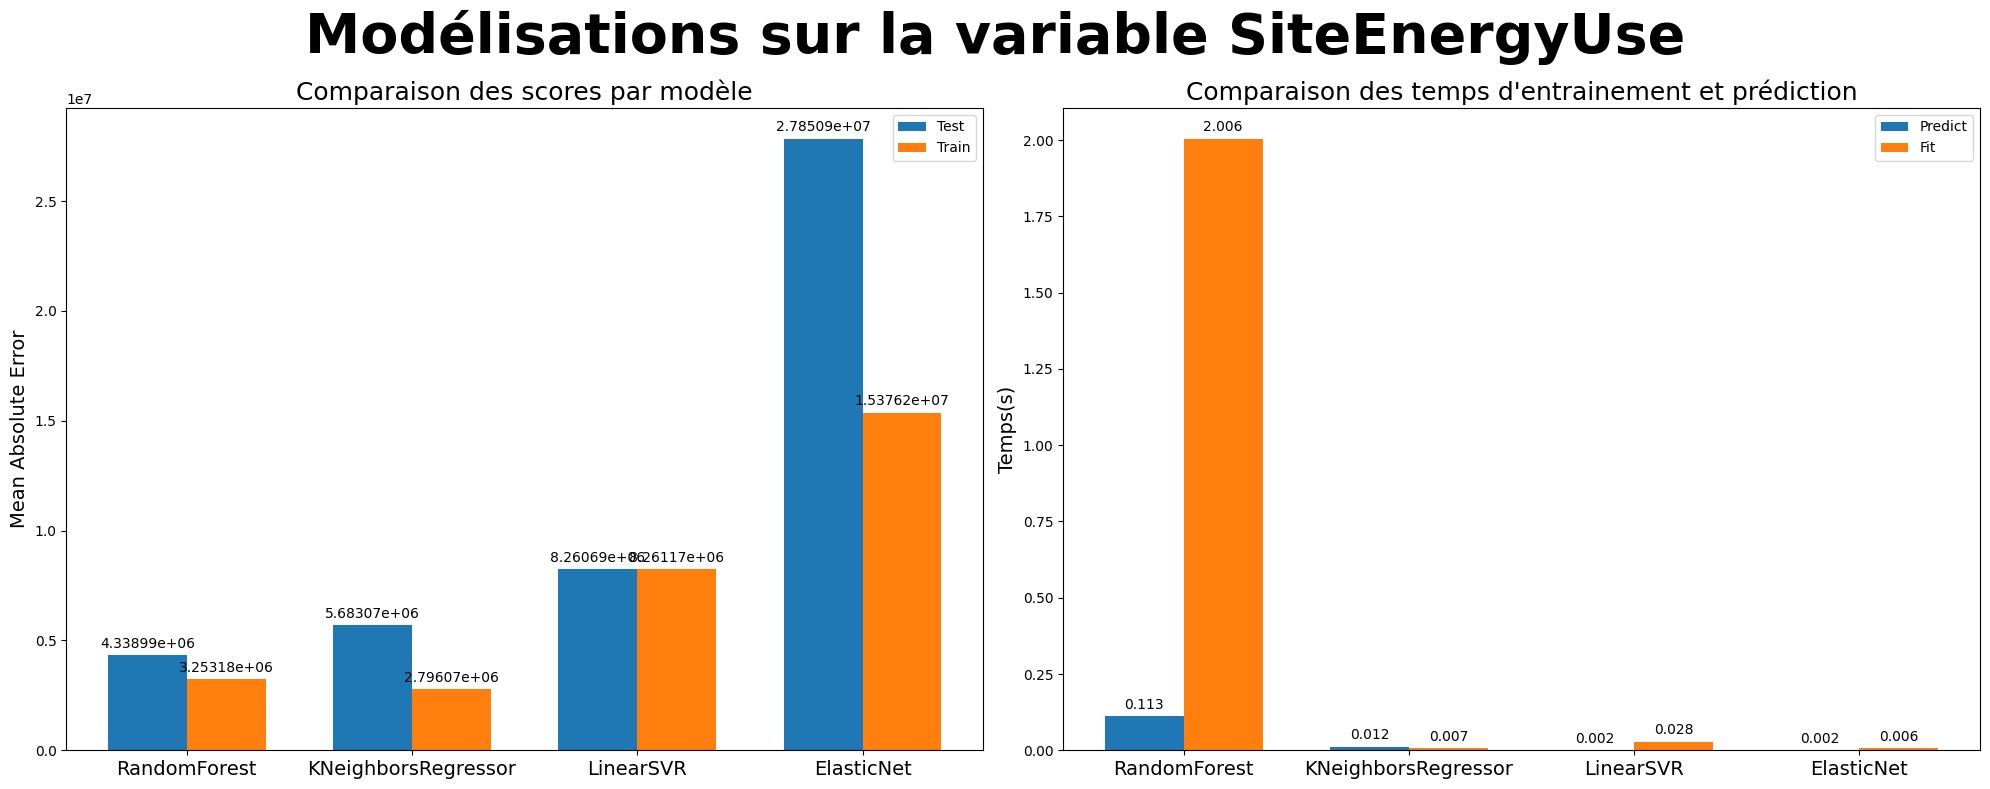

In [75]:
#On enlève le modèle LinearRegression par soucis de lisibilité (échelle)
SEU_final_metrics_compare = SEU_final_metrics_compare[SEU_final_metrics_compare.index != 'LinearRegression']
pf.plotComparaisonResults(SEU_final_metrics_compare, 'SiteEnergyUse')

**Observations**

- le modèle RandomForest offre le meilleur score MAE en terme de prédiction. 
- le modèle KNeighborsRegressor offre le meilleur score MAE en terme d'entrainement.
- L'entrainement et la prédiction du modèle RandomForest prend plus de temps que les autres modèles

**Nous allons séléctionner le modèle RandomForestRegressor pour prédire la variable SiteEnergyUse**.


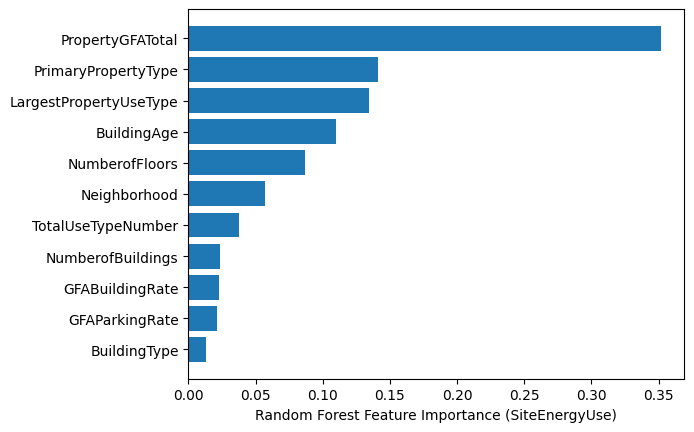

In [57]:
feature_importance = SEU_rfr_model.named_steps['grid_search_rfr'].best_estimator_.regressor_.feature_importances_ 
features_names = pf.get_feature_names(SEU_rfr_model.named_steps['preprocessor'])
features_names = np.array(features_names)

sorted_idx = feature_importance.argsort()
plt.barh(features_names[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Random Forest Feature Importance (SiteEnergyUse)")
plt.show()

La surface totale de la propriété a une importance bien supérieure aux autres variables.

### 3.2 Modèle de prédiction des émissions de CO2
**comparaison les métriques obtenues sur les différents modèles** 

In [58]:
GHG_compare_metrics = pd.concat([pd.DataFrame(GHG_rfr_results[metrics].mean(), columns=['RandomForest']),
           pd.DataFrame(GHG_knr_results[metrics].mean(), columns=['KNeighborsRegressor']),
           pd.DataFrame(GHG_svr_results[metrics].mean(), columns=['LinearSVR']),
           pd.DataFrame(GHG_eNet_results[metrics].mean(), columns=['ElasticNet']),
           pd.DataFrame(GHG_mlr_results[metrics].mean(), columns=['LinearRegression'])
          ], axis=1)
GHG_final_metrics_compare = pd.DataFrame(columns=metrics, 
                                     index=['RandomForest','KNeighborsRegressor',
                                            'LinearSVR','ElasticNet',
                                            'LinearRegression'])
for m in metrics:
    GHG_final_metrics_compare[m] = GHG_compare_metrics.loc[m]
GHG_final_metrics_compare

,mean_fit_time,mean_score_time,mean_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error
RandomForest,1.778086,0.100313,-1.219132e+02,-9.414094e+01
KNeighborsRegressor,0.007057,0.013479,-1.385576e+02,-7.038503e+01
LinearSVR,0.037624,0.001803,-1.444505e+42,-1.310789e+45
ElasticNet,0.006171,0.001842,-7.071487e+02,-3.985239e+02
LinearRegression,0.002667,0.000781,-4.001734e+03,-1.895106e+03


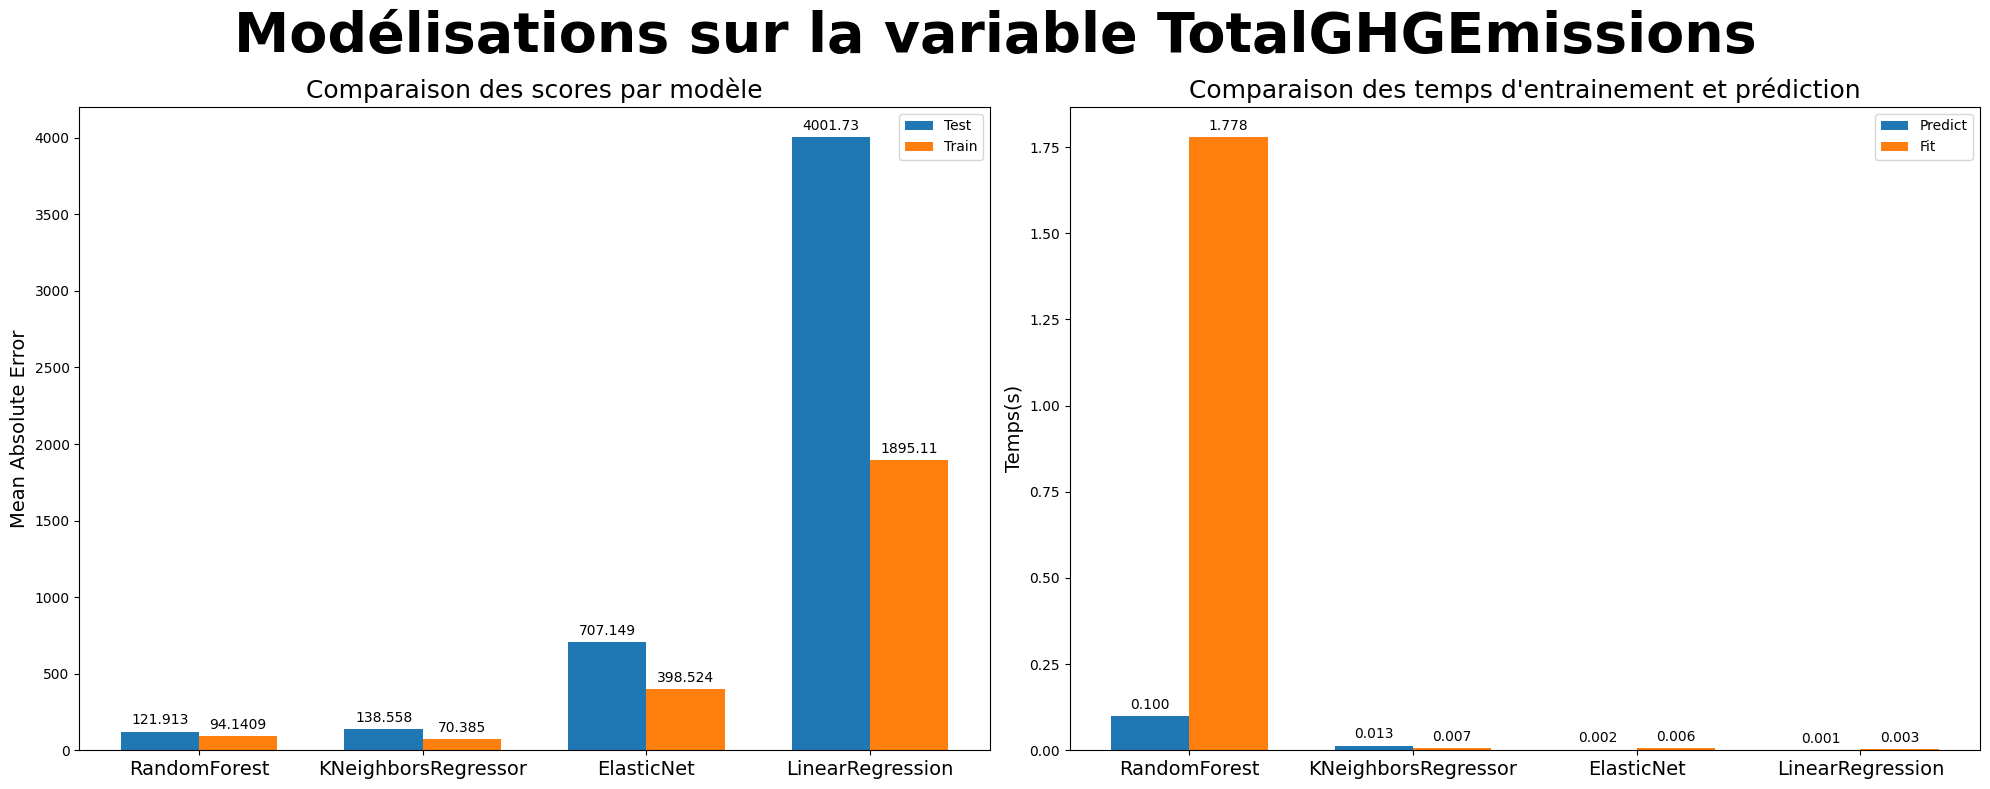

In [59]:
#On enlève le modèle LinearSVR par soucis de lisibilité (échelle)
GHG_final_metrics_compare = GHG_final_metrics_compare[GHG_final_metrics_compare.index != 'LinearSVR']


pf.plotComparaisonResults(GHG_final_metrics_compare, 'TotalGHGEmissions')

**Observations**

- le modèle RandomForest offre le meilleur score MAE en terme de prédiction. 
- le modèle KNeighborsRegressor offre le meilleur score MAE en terme d'entrainement.
- L'entrainement et la prédiction du modèle RandomForest prend plus de temps que les autres modèles

**Nous allons séléctionner le modèle RandomForestRegressor pour prédire la variable SiteEnergyUse**.


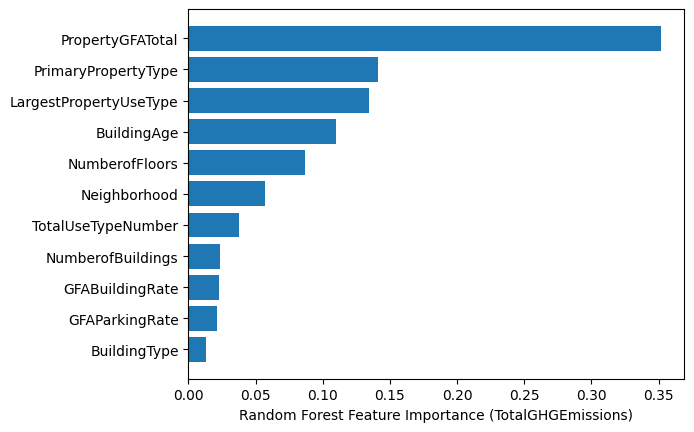

In [60]:
feature_importance = GHG_rfr_model.named_steps['grid_search_rfr'].best_estimator_.regressor_.feature_importances_ 
features_names = pf.get_feature_names(GHG_rfr_model.named_steps['preprocessor'])
features_names = np.array(features_names)

sorted_idx = feature_importance.argsort()
plt.barh(features_names[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Random Forest Feature Importance (TotalGHGEmissions)")
plt.show()

Les surfaces (GFA) de la propriété et le type d'utilisation principale ont un poids plus important dans les décisions de notre modèle. En revanche, le type de bâtiment a un impact très limité. On remarque également que l'age du batiment ou encore son emplacement géographique n'ont pas un impact très important non plus.

## 4. TEST DES MODELES SELECTIONNES

Nous allons à présent tester les modèles sélectionnés sur nos données test et vérifier leurs performances

In [61]:
sns.set_palette(sns.dark_palette("purple", reverse="True"))

### 4.1 Prédiction des consommations d'énergie

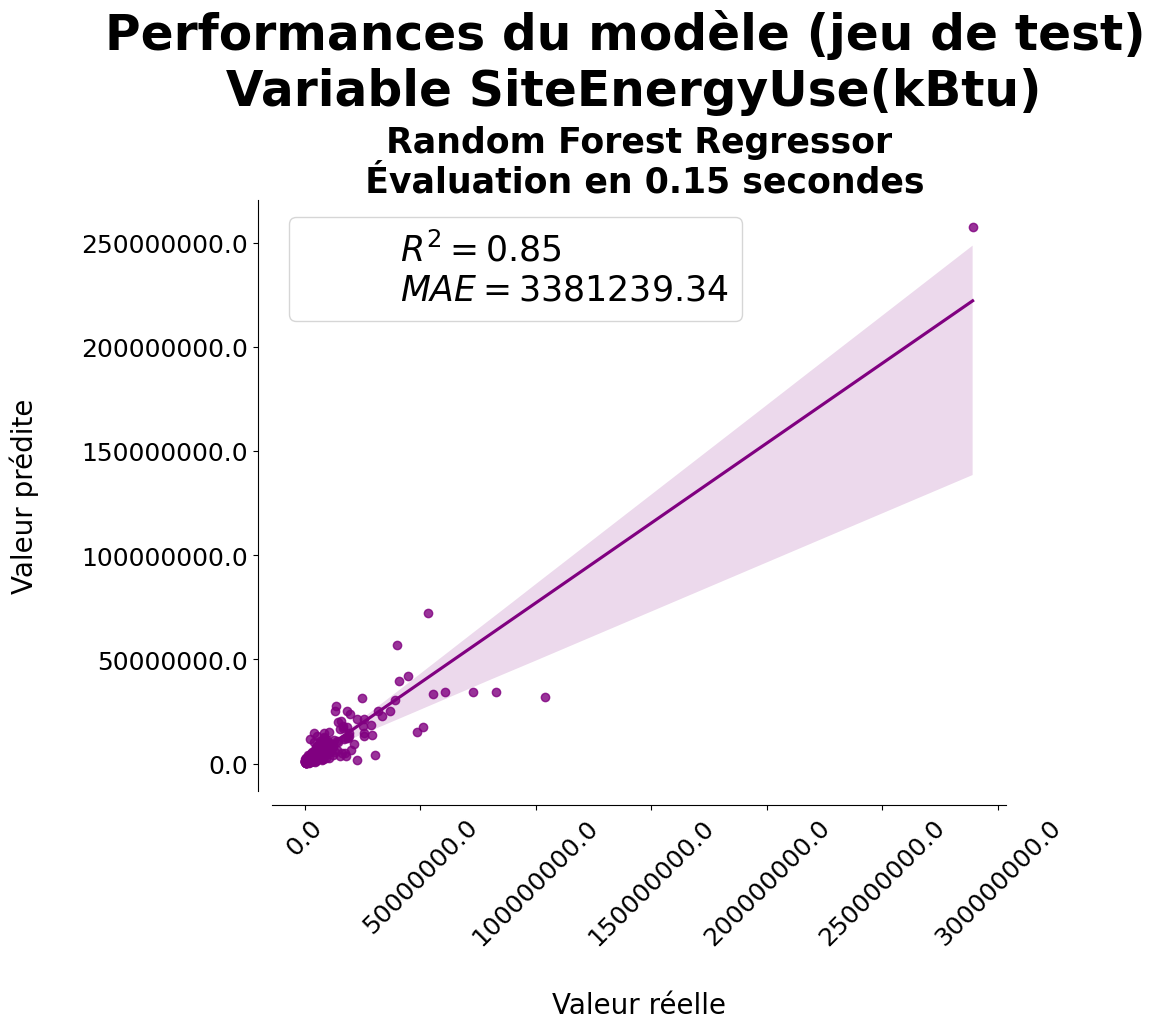

In [62]:
# Re-entrainement  
SEU_rfr_model = rfr_grid_cv.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])

estimators1 = {"Random Forest Regressor" : SEU_rfr_model}

# Prédiction sur le jeu de test
r2_mae_time_SEU_Test = pf.predictPlot(estimators1, X_test,Y_test['SiteEnergyUse(kBtu)'], 'SiteEnergyUse(kBtu)')

In [63]:
# Récupération des métriques Train et Test

SEU_rfr_results = pf.model_scores(SEU_rfr_model, 'grid_search_rfr', X_train)
r2_mae_time_SEU_Train = pd.DataFrame()

r2_mae_time_SEU_Train.loc['Train', "MAE"] = SEU_rfr_model.named_steps['grid_search_rfr'].best_score_
r2_mae_time_SEU_Train.loc['Train', "R2"] = np.mean(SEU_rfr_results[SEU_rfr_results.rank_test_r2 == 1]['mean_test_r2'])
r2_mae_time_SEU_Train.loc['Train', "Time"] = round((np.mean(SEU_rfr_results.mean_fit_time)*X_train.shape[0]),2)

r2_mae_time_SEU_Train['MAE'] = -r2_mae_time_SEU_Train['MAE']
r2_mae_time_SEU_Train

Meilleur score MAE : -3890903.526
Meilleur Score R2 : 0.607
Meilleurs paramètres : {'regressor__bootstrap': False, 'regressor__max_depth': 15, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Temps moyen d'entrainement : 2397.47s


,MAE,R2,Time
Train,3.890904e+06,0.60745,2397.47


In [64]:
r2_mae_time_SEU_Test = r2_mae_time_SEU_Test.rename(index={'Random Forest Regressor': 'Test'})
r2_mae_time_SEU_Test

,MAE,R2,Time
Test,3.381239e+06,0.849294,0.151598


In [65]:
r2_mae_time_SEU_Train_Test = pd.concat([r2_mae_time_SEU_Train,r2_mae_time_SEU_Test])
r2_mae_time_SEU_Train_Test

,MAE,R2,Time
Train,3.890904e+06,0.607450,2397.470000
Test,3.381239e+06,0.849294,0.151598


**Observations**

- **Les métriques sur le jeu de données de test sont améliorées comparativement aux métriques obtenues avec la GridSearch** avec le modèle de RandomForestRegressor

- Pas de sur-apprentissage observé

### 4.2 Prédiction des émissions en CO2

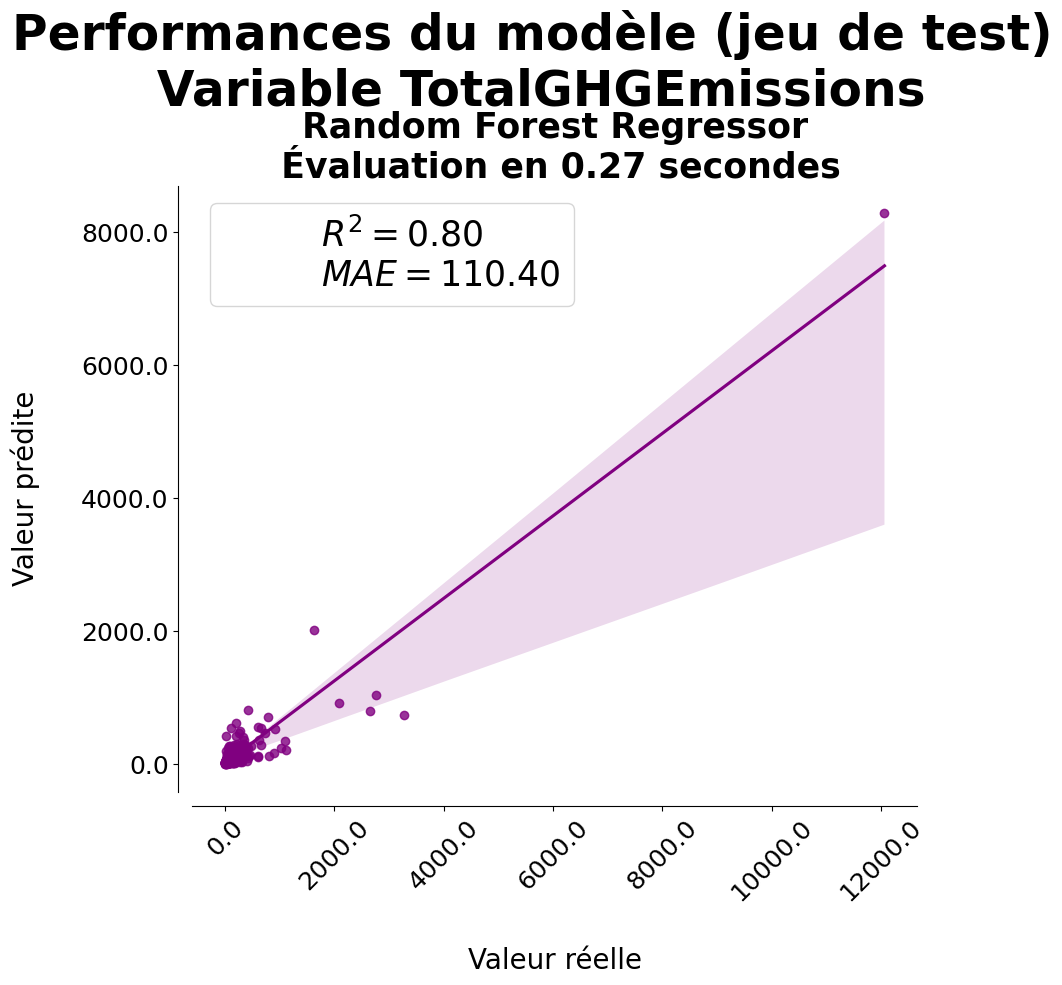

In [69]:
# Re-entrainement
GHG_rfr_model = rfr_grid_cv.fit(X_train, Y_train['TotalGHGEmissions'])

estimators2 = {"Random Forest Regressor" : GHG_rfr_model}

# Prédiction sur le jeu de test
r2_mae_time_GHG_Test = pf.predictPlot(estimators2, X_test,Y_test['TotalGHGEmissions'], 'TotalGHGEmissions')

In [70]:
# Récupération des métriques Train et Test

GHG_rfr_results = pf.model_scores(GHG_rfr_model, 'grid_search_rfr', X_train)
r2_mae_time_GHG_Train = pd.DataFrame()

r2_mae_time_GHG_Train.loc['Train', "MAE"] = GHG_rfr_model.named_steps['grid_search_rfr'].best_score_
r2_mae_time_GHG_Train.loc['Train', "R2"] = np.mean(GHG_rfr_results[GHG_rfr_results.rank_test_r2 == 1]['mean_test_r2'])
r2_mae_time_GHG_Train.loc['Train', "Time"] = round((np.mean(GHG_rfr_results.mean_fit_time)*X_train.shape[0]),2)

r2_mae_time_GHG_Train['MAE'] = -r2_mae_time_GHG_Train['MAE']
r2_mae_time_GHG_Train

Meilleur score MAE : -111.52
Meilleur Score R2 : 0.51
Meilleurs paramètres : {'regressor__bootstrap': False, 'regressor__max_depth': 15, 'regressor__max_features': 'log2', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 700}
Temps moyen d'entrainement : 2423.45s


,MAE,R2,Time
Train,111.520448,0.509821,2423.45


In [71]:
r2_mae_time_GHG_Test = r2_mae_time_GHG_Test.rename(index={'Random Forest Regressor': 'Test'})
r2_mae_time_GHG_Test

,MAE,R2,Time
Test,110.402443,0.80409,0.269296


In [76]:
r2_mae_time_GHG_Train_Test = pd.concat([r2_mae_time_GHG_Train,r2_mae_time_GHG_Test])
r2_mae_time_GHG_Train_Test

,MAE,R2,Time
Train,111.520448,0.509821,2423.450000
Test,110.402443,0.804090,0.269296


**Observations**

- **Les métriques sur le jeu de données de test sont améliorées comparativement aux métriques obtenues avec la GridSearch** avec le modèle de RandomForestRegressor

- Pas de sur-apprentissage observé

In [73]:
# Export des données pour analyser l'importance de l'energystar score
data_filter['energystar_score'] = energystar_score
data_filter.to_csv('data_filter.csv')